In [1]:
%%capture
!apt install libkrb5-dev
## Let's install Apache Spark on Colab

!wget https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz -P "/content/"
!tar xf spark-3.5.3-bin-hadoop3.tgz
!pip install findspark

import os

os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user
! python pip install pymongo --user

In [2]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [3]:
! python -m pip install pymongo==4.10.1
import pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 23.9 MB/s eta 0:00:00


public SparkSession.Builder appName(String name)
Sets a name for the application, which will be shown in the Spark web UI. If no application name is set, a randomly generated name will be used.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('BDA').getOrCreate()


In [5]:
import numpy as np
import pandas as pd
import matplotlib

#misc
import gc
import time
import warnings

import pymongo
#graph section
import networkx as nx
#import heapq  # for getting top n number of things from list,dict
import pandas as pd
import numpy as np

# JSON parsing
import json

# HTML parsing
from lxml import etree
import urllib

# SQLite RDBMS
import sqlite3

# Time conversions
import time

# Parallel processing
# import swifter
#  PyMongo is a Python distribution containing tools for working with MongoDB,
# and is the recommended way to work with MongoDB from Python.
# MongoDB is a source-available cross-platform document-oriented database program. Classified
# as a NoSQL database program, MongoDB uses JSON-like documents with optional schemas
# NoSQL DB, an open-source document database and leading NoSQL database.
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

#
import os
# The OS module in python provides functions for interacting with the operating system. OS, comes under Python's standard utility modules. This module provides a portable way of using operating system dependent functionality
os.environ['SPARK_HOME'] = "/content/spark-3.5.3-bin-hadoop3" #change this here

# PySpark is the Python API written in python to support Apache Spark.
# Apache Spark is written in Scala and can be integrated with Python, Scala, Java, R, SQL languages
import pyspark
# SQLContext is a class and is used for initializing the functionalities of Spark SQL.
# SparkContext class object (sc) is required for initializing SQLContext class object.
from pyspark.sql import SQLContext

In [6]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


In [7]:
# Minimal class to download shared files from Google Drive.
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='11lwBibxX7PYGgOfHU25_dDDDsPX1Pt0Y',
                                    dest_path='/content/yelp_business.csv')


In [8]:
# read command but format as “CSV” to read csv files in Spark
# spark is not able to read columns properly from csv file
#  “inferSchema” and “header” to true, we can let spark know that first row in data is header
yelp_business_sdf = spark.read.format("csv").option("header", "true").load("yelp_business.csv")

# createOrReplaceTempView() creates/replaces a local temp view with the dataframe provided.
# Lifetime of this view is dependent to SparkSession
yelp_business_sdf.createOrReplaceTempView('yelp_business')


In [9]:
yelp_business_sdf.show(5)

+--------------------+--------------------+------------+--------------------+--------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+
|         business_id|                name|neighborhood|             address|          city|state|postal_code|  latitude|   longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+------------+--------------------+--------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|    Dental by Design|        NULL|4855 E Warner Rd,...|     Ahwatukee|   AZ|      85044|33.3306902|-111.9785992|  4.0|          22|      1|Dentists;General ...|
|He-G7vWjzVUysIKrf...| Stephen Szabo Salon|        NULL|  3101 Washington Rd|      McMurray|   PA|      15317|40.2916853| -80.1048999|  3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|Western Motor Veh...|        NULL|6025 N 27th Ave, ...|       P

In [10]:
avg_reviews_by_city_sdf = spark.sql('select city, avg(stars) as avg_rating from yelp_business yb '\
                                             'group by city')

avg_reviews_by_city_sdf.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[city#21], functions=[avg(cast(stars#26 as double))])
   +- Exchange hashpartitioning(city#21, 200), ENSURE_REQUIREMENTS, [plan_id=45]
      +- HashAggregate(keys=[city#21], functions=[partial_avg(cast(stars#26 as double))])
         +- FileScan csv [city#21,stars#26] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/yelp_business.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<city:string,stars:string>




In [11]:
same_city_sdf = spark.sql('select b1.name, b2.name from yelp_business b1 join yelp_business b2 '\
                                             ' on b1.city = b2.city and b1.name <> b2.name')

same_city_sdf.show(5)

+----------------+--------------------+
|            name|                name|
+----------------+--------------------+
|Dental by Design|      My Wine Cellar|
|Dental by Design|Florencia Pizza B...|
|Dental by Design|           Hi-Health|
|Dental by Design|       Barro's Pizza|
|Dental by Design|Healthy and Clean...|
+----------------+--------------------+
only showing top 5 rows



In [12]:
same_city_sdf.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [name#18, name#119]
   +- BroadcastHashJoin [city#21], [city#122], Inner, BuildRight, NOT (name#18 = name#119), false
      :- Filter (isnotnull(city#21) AND isnotnull(name#18))
      :  +- FileScan csv [name#18,city#21] Batched: false, DataFilters: [isnotnull(city#21), isnotnull(name#18)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/yelp_business.csv], PartitionFilters: [], PushedFilters: [IsNotNull(city), IsNotNull(name)], ReadSchema: struct<name:string,city:string>
      +- BroadcastExchange HashedRelationBroadcastMode(List(input[1, string, false]),false), [plan_id=148]
         +- Filter (isnotnull(city#122) AND isnotnull(name#119))
            +- FileScan csv [name#119,city#122] Batched: false, DataFilters: [isnotnull(city#122), isnotnull(name#119)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/yelp_business.csv], PartitionFilters: [], PushedFilters: [IsNotNull(city), IsNotNul

In [13]:
!pip install money-parser

## 2.1 A Simple Program to Read from the Web and Invoke Spark

The cell below uses the **Pandas** library to read a table from the given web page (the Wikipedia information on films in the year 2010).  The code loads this into a list of **DataFrame**s called `films_2010`.  We then pull the table at index 3, then do some simple **data wrangling** on `top_films` to set up the appropriate types.

Select the Cell below and then select the Run button which appeared over the brackets.

In [14]:
import pandas as pd
from money_parser import price_dec

def extract_number(x):
  return round(price_dec(x) / 1000000, 2)

films_2007 = pd.read_html('https://en.wikipedia.org/wiki/2007_in_film')

top_films = films_2007[3]

top_films.set_index('Rank', inplace=True)

top_films['Revenue (millions)'] = top_films['Worldwide gross'].apply(extract_number)

top_films

,Title,Distributor,Worldwide gross,Revenue (millions)
Rank,,,,
1,Pirates of the Caribbean: At World's End,Disney,"$963,400,492",963.40
2,Harry Potter and the Order of the Phoenix,Warner Bros.,"$941,676,843",941.68
3,Spider-Man 3,Sony,"$895,871,626",895.87
4,Shrek the Third,Paramount,"$813,367,380",813.37
5,Transformers,Paramount,"$709,709,780",709.71
6,Ratatouille,Disney,"$623,726,085",623.73
7,I Am Legend,Warner Bros.,"$585,410,052",585.41
8,The Simpsons Movie,20th Century Fox,"$536,414,270",536.41
9,National Treasure: Book of Secrets,Disney,"$459,242,249",459.24


Can we programmatically compute how many entries were scored as top films?

---

In [16]:
# You can use the Python len() function on a dataframe to figure out how many rows!

# TODO: Update dataframe_length with your code here!
dataframe_length = len(top_films)
dataframe_length


10

Now we will copy the table over to **Apache Spark**, which is a big data engine capable of processing giant tables.

We will **query** the table to get top films from Disney.

In [22]:

# This loads a Pandas DataFrame into Apache Spark
top_films_spark = spark.createDataFrame(top_films)

# Now use Spark to filter only those rows in Towne 100
disney_films = top_films_spark.filter(top_films_spark.Distributor == 'Warner Bros.')
display(disney_films.collect())

[Row(Title='Harry Potter and the Order of the Phoenix', Distributor='Warner Bros.', Worldwide gross='$941,676,843', Revenue (millions)=Decimal('941.680000000000000000')),
 Row(Title='I Am Legend', Distributor='Warner Bros.', Worldwide gross='$585,410,052', Revenue (millions)=Decimal('585.410000000000000000')),
 Row(Title='300', Distributor='Warner Bros.', Worldwide gross='$456,068,181', Revenue (millions)=Decimal('456.070000000000000000'))]

\Congratulations, you have just run a very simple Spark program!

## 2.2 Something a Little More Fun
Running the cell below will create a scatter plot.

**Your task is to edit this cell such that:***

1. The text (which says “BDA student”) should be replaced with your full name.
2. The number of values sampled should be 625, and you should  change the figure title to match.

4. The x-axis should be labeled “Index”.

You may run this cell repeatedly to see the output.

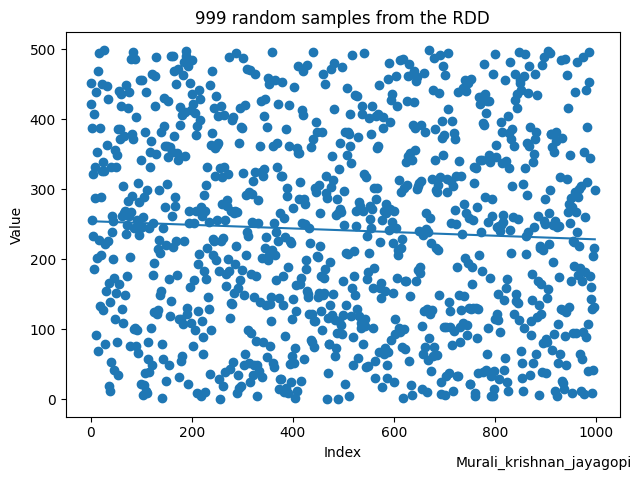

In [23]:
# We’ll be using Matplotlib to plot a visualization
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Create a Spark dataset with values 0 thru 499
rdd = spark.sparkContext.parallelize(range(500))

# Sample 350 values from the RDD
y = np.array(rdd.takeSample(True, 999, 1))
# Create an array with the indices
x = np.array(range(len(y)))

# Create a plot with a caption, X and Y legends, etc
x_label = 'Index'
y_label = 'Value'
student = 'Murali_krishnan_jayagopi'

plt.title(str(len(y)) + ' random samples from the RDD')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.figtext(0.995, 0.01, student, ha='right', va='bottom')
# Scatter plot that fits within the box
plt.scatter(x, y)
plt.tight_layout()

# Now fit a trend line to the data and plot it over the scatter plot
m, c = np.polyfit(x, y, 1)
plt.plot(x, m*x + c)

# Save the SVG
plt.savefig('hw0.svg')

The following test cell prints your name and tests whether you followed the directions.

In [20]:
print("Your name is:", student)

Your name is: Murali_krishnan_jayagopi


Part 3: Submitting Your Homework

First, note that it's easy to "break" your notebook by changing something...  So you should *ALWAYS* clear output and re-run your code, just to make sure that hasn't happened.

When you are done, select the "Runtime" menu at the top of the window. Then, select "Restart and run all". Please make sure all cells complete!